<a href="https://colab.research.google.com/github/omi0789/Neural-style-transfer/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Setting device


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#
Transformer

In [ ]:
transform=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor()])

Image_loader

In [ ]:
def image_loader(imgage_name):
  image=Image.open(imgage_name)
  image=transform(image).unsqueeze(0)
  return image.to(device,torch.float)

##Image Path

In [ ]:
image_dir="./sample_data"
content_img=image_loader(image_dir+"/photo.png")
style_img=image_loader(image_dir+"/vg_starry_night.jpg")

# Step 1: Remove the batch dimension using squeeze
content_img = content_img.squeeze(0)
print("After squeeze:", content_img.shape)  # Output: (4, 512, 512)

# Step 2: Reduce the channel dimension to 3
# Method 1: Slice the first 3 channels
content_img = content_img[:3, :, :]
print("After slicing:", content_img.shape)  # Output: (3, 512, 512)

# Step 3: Add back the singleton dimension for the second axis
content_img = content_img.unsqueeze(1)
print("Final shape:", content_img.shape)  # Output: (3, 1, 512, 512)

content_img=content_img.permute(1,0,2,3)
print("Final shape:", content_img.shape)  # Output: (1, 3, 512, 512)


After squeeze: torch.Size([4, 512, 512])
After slicing: torch.Size([3, 512, 512])
Final shape: torch.Size([3, 1, 512, 512])
Final shape: torch.Size([1, 3, 512, 512])


In [ ]:
print(content_img.shape)
print(style_img.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [ ]:
assert style_img.size()==content_img.size(), "We Need both of same size"

#Displaying the Image Inputted


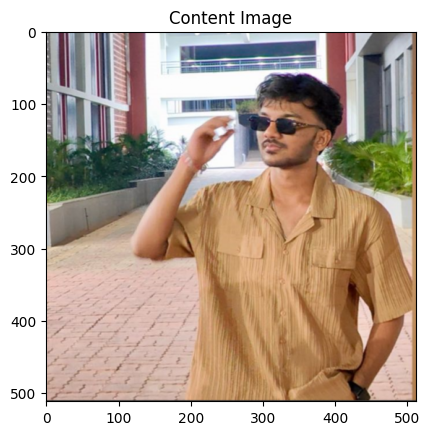

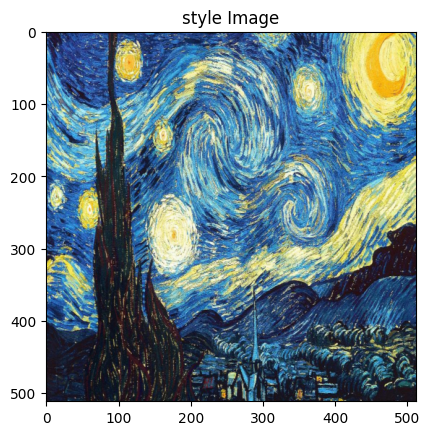

In [ ]:
def imshow(tensor,title=None):
  # unloader = transforms.ToPILImage()
  image=tensor.cpu().clone()
  image=image.detach()
  image=image.squeeze(0)#Remove the extra dimension
  image=image.permute(1,2,0)#because imshow requires color channel as last
  # image=unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
imshow(content_img,title="Content Image")
plt.figure()
imshow(style_img,title="style Image")

#Content loss and style loss

In [ ]:
#The Gram matrix is a mathematical tool used in style transfer to capture the style of an image.
#It measures how features in a feature map (like edges, textures, and patterns) are correlated with each other.


class ContentLoss(nn.Module):
    def __init__(self,target):
      super(ContentLoss,self).__init__()

      #The target content is "detached" from the computation graph because we don't want to modify it during training.
      # The target image is fixed and we will update the generated image to match this target's content.
      self.target=target.detach()

    def forward(self,input):
      self.loss=F.mse_loss(input,self.target)
      return input

def gram_matrix(input):
  a,b,c,d=input.size()
  #a is the batch size (usually 1 for style transfer).
  #b is the number of feature maps (channels).
  # c and d are the spatial dimensions (height and width) of each feature map.

  feature=input.view(a*b,c*d)# Flatten

  gram=torch.mm(feature,feature.t())#gram can be calculated by inner product of feature map and its transpose

  #Normalize the gram value by dividing it
  return gram.div(a*b*c*d)


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Calculate the Gram matrix for the target feature (style image) and detach it
        # Detaching ensures that the target doesn't get updated during training
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        # Compute the Gram matrix for the input (generated image's feature map)
        gram = gram_matrix(input)
        # Calculate the style loss as the mean squared error between the two Gram matrices
        self.loss = F.mse_loss(gram, self.target)
        return input


#Importing Pretrained Model

In [ ]:

# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network are normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 55.2MB/s]


In [ ]:
#Create a module to normalize input image so we can easily put it in nn.Sequential
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization,self).__init__()
      # .view the mean and std to make them [C x 1 x 1] so that they can
      # directly work with image Tensor of shape [B x C x H x W].
      # B is batch size. C is number of channels. H is height and W is width
    self.mean=torch.tensor(mean).view(-1,1,1)
    self.std=torch.tensor(std).view(-1,1,1)

  def forward(self,img):
    return (img-self.mean)/self.std


In [ ]:
#desired depth layer to compute style/content loss:
content_layers_default=['conv_4']
style_layers_default=['conv_1','conv_2','conv_3','conv_4','conv_5']

##Get Content & Style Loss

In [ ]:
def get_style_content_model_and_losses(cnn,normalization_mean,normalization_std,
                                       style_img,content_img,
                                       content_layers=content_layers_default,
                                       style_layers=style_layers_default):
  cnn=copy.deepcopy(cnn)

  normalization=Normalization(normalization_mean,normalization_std).to(device)

  #losses
  content_losses=[]
  style_losses=[]

  ## assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
  # to put in modules that are supposed to be activated sequentially
  model=nn.Sequential(normalization)

  i=0
  for layer in cnn.children():
    if isinstance(layer,nn.Conv2d):
      i+=1
      name="conv_{}".format(i)
    elif isinstance(layer,nn.ReLU):
      name='relu_{}'.format(i)
      # The in-place version doesn't play very nicely with the ContentLoss
      # and StyleLoss we insert below. So we replace with out-of-place
      # ones here.
      layer=nn.ReLU(inplace=False)
    elif isinstance(layer,nn.MaxPool2d):
      name='pool_{}'.format(i)
    elif isinstance(layer,nn.BatchNorm2d):
      name='bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name,layer)

    if name in content_layers:
      #Add content loss
      target=model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      # add style loss:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # # now we trim off the layers after the last content and style losses
  for i in range(len(model) - 1, -1, -1):
    if isinstance(list(model.children())[i], ContentLoss) or isinstance(list(model.children())[i], StyleLoss):
        break

  model=model[:(i+1)]#This line trims the model to include only up to the last layer where a ContentLoss or StyleLoss module was added.

  return model,style_losses,content_losses

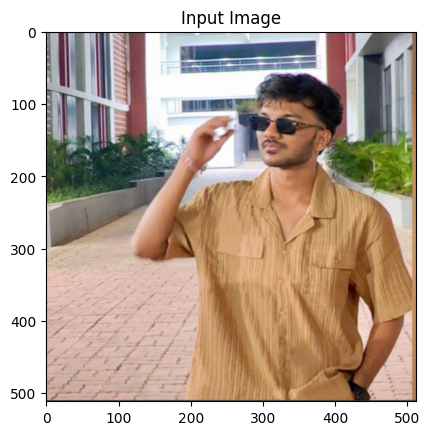

In [ ]:
input_img=content_img.clone()

plt.figure()
imshow(input_img,title='Input Image')

In [ ]:
# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

#Run style Transfer

In [ ]:
## It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn,normalization_mean,normalization_std,
                       content_img,style_img,input_img,num_steps=300,
                       content_weight=1,style_weight=10000):
  """Run the style transfer."""
  print('Building the style transfer model..')#alpha=content_weight
  optimizer=get_input_optimizer(input_img)#beta=style_weight

  model, style_losses, content_losses = get_style_content_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

  print('Optimzing....')

  run=[0]
  while run[0]<=num_steps:

    def closure():
      #correct value of input beyween 0 and 1
      input_img.data.clamp_(0,1)

      optimizer.zero_grad()
      model(input_img)

      style_score=0
      content_score=0

      for style in style_losses:
        style_score+=style.loss

      for content in content_losses:
        content_score+=content.loss

      style_score*=style_weight#alpha L +beta R research paper
      content_score*=content_weight

      loss=style_score+content_score
      loss.backward()

      run[0]+=1
      if run[0]%50==0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            style_score.item(), content_score.item()))
        print()

      return style_score+content_score

    optimizer.step(closure)

  input_img.data.clamp_(0,1)

  return input_img


#Get Output

In [ ]:
output = run_style_transfer(cnn,cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=1000
                            )


plt.figure()
imshow(output,title='Output Image')

Building the style transfer model..


<ipython-input-29-9e1a94edbadd>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean=torch.tensor(mean).view(-1,1,1)
<ipython-input-29-9e1a94edbadd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std=torch.tensor(std).view(-1,1,1)


Optimzing....
run [50]:
Style Loss : 2.850030 Content Loss: 22.959820

run [100]:
Style Loss : 2.134413 Content Loss: 18.226204

run [150]:
Style Loss : 2.000045 Content Loss: 17.234112

run [200]:
Style Loss : 2.142093 Content Loss: 17.039215

run [250]:
Style Loss : 2084.720459 Content Loss: 67.750450

run [300]:
Style Loss : 114914.914062 Content Loss: 356.282166

run [350]:
Style Loss : 2.885168 Content Loss: 25.121420

run [400]:
Style Loss : 3.674025 Content Loss: 19.447432

run [450]:
Style Loss : 2.145174 Content Loss: 18.131990

run [500]:
Style Loss : 1.954584 Content Loss: 17.469357

run [550]:
Style Loss : 1.912668 Content Loss: 17.350952

